# Flower를 활용한 연합학습 소개

Flower를 활용한 KAICD 연합학습 강좌에 오신 것을 환영합니다!

이 노트북은 Flower와 PyTorch를 이용한 연합학습 시스템을 구축하는 내용을 담고 있습니다.

Part 1에서는 PyTorch를 활용하여 모델 학습 파이프라인과 데이터를 불러오는 과정을 배우고,

Part 2에서는 Flower를 이용하여 PyTorch 기반 파이프라인을 연합학습에 적용하는 과정을 배울 예정입니다.

## Part 0: 사전준비

시작하기에 앞서, Google Colab GPU 가속 설정을 확인해야 합니다.

`런타임 > 런타임 유형 변경 > 하드웨어 가속: GPU > 저장`

### 의존성 설치

다음으로, PyTorch (`torch` 및 `torchvision`)와 Flower (`flwr`)에 필요한 패키지를 설치합니다:

In [1]:
!pip install torch==1.9.0 torchvision==0.10.0 git+https://github.com/adap/flower.git@release/0.17#egg=flwr["simulation"]

  Cloning https://github.com/adap/flower.git (to revision release/0.17) to /tmp/pip-install-ebr32pbk/flwr_6d540892a14f4376a785bc08c0f7f621
  Running command git clone -q https://github.com/adap/flower.git /tmp/pip-install-ebr32pbk/flwr_6d540892a14f4376a785bc08c0f7f621
  Running command git checkout -b release/0.17 --track origin/release/0.17
  Switched to a new branch 'release/0.17'
  Branch 'release/0.17' set up to track remote branch 'release/0.17' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


이제 필요한 패키지를 설치했으니, 이 튜토리얼에 필요한 모든 것을 가져올 수 있습니다:

In [2]:
from collections import OrderedDict
from typing import List

import flwr as fl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

print("numpy", np.__version__)
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

numpy 1.19.5
torch 1.9.0+cu111
torchvision 0.10.0+cu111
Training on cuda:0


Google Colab에서 실행하고 런타임에 GPU 가속기가 있다면, 출력 결과에서 `Training on cuda:0` 문장을 확인할 수 있습니다.


### 데이터 불러오기

연합학습은 여러 도메인에 걸쳐 다양한 유형의 작업에 적용할 수 있습니다.

이 튜토리얼에서는 CIFAR-10를 사용하여, 합성곱 신경망(Convolutional Neural Network, CNN)을 훈련시키는 과정을 연합학습에 적용하고자 합니다.

CIFAR-10는 10가지 클래스를 가지고 있는 이미지 데이터 세트이며, 딥러닝 분야에서 이미지 분류기를 훈련시키고 테스트하는데 널리 사용되고 있습니다.

In [3]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

기본 설정이 끝났으니, 이제 CIFAR-10 데이터 세트를 여러 파티션으로 분할하여 여러 참여기관이 여러 데이터 세트를 갖는 시뮬레이션을 수행할 예정입니다.

각 파티션은 단일 참여기관의 데이터를 나타냅니다.

여기서는 연합학습 시뮬레이션을 목적으로 데이터를 분할했지만,

현실에서는 각 참여기관마다 고유한 데이터를 가지고 있기 때문에 데이터 분할이 필요치 않습니다.

각 참여기관은 연합학습 시스템에서 클라이언트 역할을 수행합니다.

따라서, 10개의 참여기관이 연합학습에 참여한다는 것은 연합학습 서버에 10개의 클라이언트가 연결되어 있음을 의미합니다.


In [4]:
NUM_CLIENTS = 10

CIFAR-10 훈련 및 테스트 데이터 세트를 불러오고, 10개의 데이터 세트로 분할(각각 훈련 및 검증 세트로 분할)하여 각각 `DataLoader`로 포장합니다:

In [5]:
def load_datasets():
    # CIFAR-10 데이터 세트를 다운로드받고, transform 옵션을 통해 변환합니다 (훈련 및 테스트).
    transform = transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # 훈련 데이터 세트를 10개의 파티션으로 분할하여 개별 데이터 세트를 시뮬레이션 합니다.
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # 분할된 각 파티션에서 훈련 및 검증 세트를 생성하고 DataLoader로 포장합니다.
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 각 분할 데이터의 1/10이 검증 데이터로 사용됩니다.
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets()

Files already downloaded and verified
Files already downloaded and verified


우리는 이제 10개의 각 참여기관의 데이터를 나타내는 10개의 훈련 및 검증 데이터 세트 (`trainloaders` 및 `valloaders`) 리스트,

1개의 `testloader` (테스트 세트는 분할하지 않음)를 가지고 있습니다.

각 `trainloader`/`valloader` 쌍에는 4,500개의 훈련 이미지 데이터와 500개의 검증 이미지 데이터가 포함되어 있습니다.

다시 한번 말씀드리지만, 해당 과정은 오로지 본 튜토리얼의 주 목적인 연합학습 시뮬레이션을 구축하기 위해서만 필요하며,

실제 연합학습 시스템은 각 참여기관이 각자의 데이터를 보유하고 있습니다 (서로 간에 데이터를 공유할 수 없는 환경을 의미합니다).

다음 단계로 진행하기에 앞서, 첫 번째 훈련 데이터 세트 (`trainloaders[0]`)의 첫 번째 이미지 및 레이블 배치를 살펴보겠습니다:

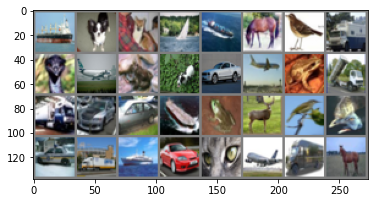

 ship   dog   dog  ship  ship horse  bird truck  bird plane  frog   dog   car plane  frog truck truck   car   car  ship  frog  deer  bird  bird   car truck  ship   car   cat plane truck horse


In [6]:
def imshow(img):
    img = img / 2 + 0.5  # 비정규화
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = iter(trainloaders[0]).next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % CLASSES[labels[j]] for j in range(32)))

## Part 1: PyTorch를 활용한 중앙집중형 학습


이제, PyTorch를 사용하여 간단한 합성곱 신경망 모델을 정의하겠습니다.

여기서는 모든 분들이 PyTorch에 대한 기본적인 이해가 있음을 가정하고, PyTorch에 대한 내용은 자세히 다루지 않겠습니다.

만약, PyTorch에 대해서 보다 깊게 배우고 싶으신 분들은 다음 링크를 추천드립니다.

[*DEEP LEARNING WITH PYTORCH: A 60 MINUTE BLITZ*](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).


### 모델 정의

[PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network)에서 설명하는 간단한 합성곱 신경망 모델을 정의합니다:

In [7]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

계속해서, 훈련과 테스트 함수를 작성합니다:

In [8]:
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # 모델 성능 측정
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(testloader.dataset)
        epoch_acc = correct / total
        # print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

### 모델 학습

이제 우리는 필요한 모든 기본 구성 요소(데이터 세트, 모델, 훈련 및 테스트 함수)를 갖추게 되었습니다!

모델을 학습시킬 차례입니다.

참여기관 중 한 곳의 데이터 세트(`trainloaders[0]`)에 대한 모델을 훈련시키기 위해 구성 요소를 조립해보도록 하겠습니다.

해당 과정은 오늘날 대부분 기계 학습 프로젝트의 현실을 반영합니다.

각 참여기관은 자체 데이터를 가지고 있으며, 이 데이터에 대한 모델을 교육하게 됩니다.

In [9]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1: validation loss 0.06227665686607361, accuracy 0.298
Epoch 2: validation loss 0.05701274228096008, accuracy 0.332
Epoch 3: validation loss 0.05538188171386719, accuracy 0.348
Epoch 4: validation loss 0.05294197964668274, accuracy 0.384
Epoch 5: validation loss 0.05192064380645752, accuracy 0.404
Final test set performance:
	loss 0.049529818141460416
	accuracy 0.4245


10개로 분할된 CIFAR-10 데이터 세트를 간단한 합성곱 신경망(CNN)을 통해 5 epoch 동안 훈련시킨 결과는 약 **45%**의 테스트 세트 정확도를 도출해낼 것입니다.

이 결과는 매우 낮다고 할 수 있으나, 이 튜토리얼의 목적상 별로 중요하지 않습니다.

연합학습을 보여드리기 이전에 단순한 중앙 집중식 훈련 파이프라인을 보여드리는 것 뿐입니다!

## Part 2: Flower를 활용한 연합학습

Part 1에서는 단순한 중앙집중식 훈련 파이프라인을 보여드렸습니다.

모든 데이터는 한 곳에 있었고, `trainloader`와 `valloader`를 통해 훈련 및 검증 데이터 세트에 접근했습니다.

만약 이러한 데이터를 한 곳에서 이용할 수 없다면(오늘날 대부분의 조직들이 처한 상황), 우리는 위에서 작성한 코드를 사용할 수 없습니다.

이제, 여러 조직에 각각의 데이터 세트가 있는 상황을 시뮬레이션 해보도록 하겠습니다!

### 모델 파라미터 업데이트

연합학습에서 서버는 전역 모델 파라미터를 클라이언트로 보내고, 클라이언트는 서버에서 수신된 모델 파라미터로 지역 모델 파라미터를 업데이트합니다.

그런 다음, 지역 데이터(모델 파라미터를 각 지역에서 업데이트)에서 모델을 훈련하고, 업데이트된 모델 파라미터 또는 그래디언트를 서버로 재전송합니다.

서버로부터 수신한 모델 파라미터를 이용하여 지역 모델을 업데이트하고, 지역 모델로부터 업데이트된 모델 파라미터를 얻기 위해서는 두 가지 기능이 필요합니다: 

`set_parameters` 및 `get_parameters`.

이 두 가지 기능은 위에서 정의한 PyTorch 모델만 해당됩니다.

이 작업이 어떻게 작동하는지에 대한 세부 사항은 여기서 자세히 다루지 않겠습니다 (보다 많은 정보는 PyTorch 문서에서 확인 가능).

우리는 PyTorch 모델 파라미터 텐서에 접근하기 위해 `state_dict`을 사용합니다.

그런 다음, 파라미터 텐서는 NumPy ndarray 리스트 형식으로 변환됩니다:

In [10]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

### Flower 클라이언트 구현

이제 진짜 연합학습을 시뮬레이션할 시간입니다!

연합학습 시스템은 하나의 서버와 여러 개의 클라이언트로 구성됩니다.

Flower에서는 `flwr.client.Client` 또는 `flwr.client.NumPyClient`의 하위 클래스를 구현하여 클라이언트를 생성합니다.

여기서는 `flwr.client.NumPyClient`를 사용하도록 하겠습니다.

왜나면 구현이 더 쉽고, 보일러 플레이트(최소한의 변경으로 여러곳에서 재사용되며, 반복적으로 비슷한 형태를 띄는 코드)를 덜 쓰기 때문이죠!

`flwr.client.NumPyClient`의 하위 클래스를 생성하고, 필요한 세 가지 함수 `get_parameters`, `fit`, `evaluate`를 구현하도록 하겠습니다:

* `get_parameters`: 현재 지역 모델의 파라미터를 반환합니다.
* `fit`: 서버로부터 모델 파라미터를 수신하고 지역 데이터에서 모델 파라미터를 훈련한 후(업데이트), 모델 파라미터를 서버로 반환합니다.
* `evaluate`: 서버로부터 모델 파라미터를 수신하고 지역 데이터의 모델 파라미터를 평가한 다음에 평가 결과를 서버로 반환합니다.

우리는 클라이언트가 이전에 정의된 PyTorch 구성 요소를 모델 교육 및 평가에 사용할 것이라고 언급했습니다.

이제, 모든 것을 하나로 묶는 간단한 구현을 살펴보겠습니다.

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

`FlowerClient`는 지역 훈련 및 평가가 어떻게 수행될 것인지 정의하고 호출할 수 있도록 합니다.

`FlowerClient`의 각 인스턴스는 연합학습 시스템에서 단일 클라이언트를 나타냅니다.

연합학습 시스템에는 여러 개의 클라이언트가 존재합니다(그렇지 않으면 연합학습을 하는 의미가 없죠?).

따라서, 각 클라이언트는 자체적인 `FlowerClient` 인스턴스로 정의됩니다.

예를 들어, 워크로드에 클라이언트가 3개라면, `FlowerClient`에 세 개의 인스턴스가 존재함을 의미합니다.

Flower는 서버가 훈련용 특정 클라이언트를 선택할 때, 각 인스턴스에서 `FlowerClient.fit`을 호출하고, `FlowerClient.evaluate`를 통해 평가합니다.

### 가상 클라이언트 엔진 사용

이 노트북에서는 단일 머신에서 10개의 클라이언트가 존재하는 연합학습 시스템을 시뮬레이션 하고자 합니다.

이는 서버와 10개의 클라이언트 모두가 단일 머신에서 CPU, GPU, 메모리 등 컴퓨터 자원을 공유한다는 뜻입니다.

클라이언트가 10개라면, 10개의 `FlowerClient` 인스턴스가 메모리를 소유하게 됩니다.

단일 컴퓨터에서 이를 수행한다면, 연합학습에 참여할 수 있는 클라이언트의 일부만 참여하더라도 사용 가능한 메모리 자원이 빠르게 소모됩니다.

Flower는 서버와 클라이언트가 여러 대의 컴퓨터에서 작동하는 정규 기능 외에도,

훈련이나 평가에 필요한 경우에만 `FlowerClient` 인스턴스를 만드는 특수한 시뮬레이션 기능을 제공합니다.

필요할 때마다 Flower 프레임워크가 클라이언트를 생성할 수 있도록 하기 위해서는,

클라이언트의 요구에 따라 Flower의 인스턴스를 생성하는 `client_fn` 함수를 구현해야 합니다.

Flower는 특정 클라이언트가 `fit` 또는 `evaluate`를 호출할 경우, `client_fn`를 호출하게 됩니다.

클라이언트는 클라이언트 ID 또는 `cid`로 식별됩니다.

예를 들어, `cid`는 각 클라이언트에 대해 서로 다른 지역 데이터 파티션을 불러오는 데 사용할 수 있습니다:

In [12]:
def client_fn(cid) -> FlowerClient:
    """단일 기관을 대표하는 Flower 클라이언트 생성(각 기관마다의 클라이언트 생성)"""

    # 모델 불러오기 (PyTorch - CNN)
    net = Net().to(DEVICE)

    # 데이터 불러오기 (CIFAR-10)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # 단일 기관을 대표하는 Flower 클라이언트 생성(각 기관마다의 클라이언트 생성)
    return FlowerClient(net, trainloader, valloader)

### 훈련 시작!

우리는 이제 특정 클라이언트에게 `fit` 또는 `evaluate`가 필요할 때마다 `FlowerClient`를 생성할 수 있는 `client_fn`를 만들었습니다!

드디어 마지막 단계입니다.

`flwr.simulation.start_simulation`를 이용하여 실제 시뮬레이션을 시작하겠습니다. 

`start_simulation`는 `FlowerClient` 인스턴스를 만드는 데 사용되는 `client_fn`, `num_clients`, `num_rounds`, `strategy` 옵션을 포함하고 있습니다.

여기서 `strategy`는 *Federated Averaging* (FedAvg)와 같은 연합학습 접근법/알고리즘을 캡슐화하는 기능을 수행합니다.

Flower는 여러가지 내장된 `strategy`를 가지고 있지만, 사용자 정의 `strategy` 또한 구현하고 사용할 수 있습니다.

본 튜토리얼에서는 `FedAvg` 구현을 기본으로 사용하고, 몇 가지 기본 파라미터를 사용하여 정의합니다.

마지막으로, 시뮬레이션을 시작하는 `start_simulation`를 호출합니다:

In [13]:
# FedAvg 전략(전역 모델 파라미터 규합 방법) 생성
strategy=fl.server.strategy.FedAvg(
        fraction_fit=1.0,  # 훈련을 위해서 사용 가능한 클라이언트의 100% 이용
        fraction_eval=0.5,  # 평가를 위해서 사용 가능한 클라이언트의 50% 이용
        min_fit_clients=10,  # 훈련을 위해서는 적어도 10개 이상의 클라이언트가 필요
        min_eval_clients=5,  # 평가를 위해서는 적어도 5개 이상의 클라이언트가 필요
        min_available_clients=10,  # 사용 가능한 클라이언트의 수가 10이 될 때까지 대기
)

# 시뮬레이션 시작
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    num_rounds=5,
    strategy=strategy
)

INFO flower 2021-10-25 01:31:38,619 | app.py:95 | Ray initialized with resources: {'GPU': 1.0, 'object_store_memory': 3907678617.0, 'accelerator_type:P100': 1.0, 'CPU': 2.0, 'node:172.28.0.2': 1.0, 'memory': 7815357236.0}
INFO flower 2021-10-25 01:31:38,629 | app.py:104 | Starting Flower simulation running: {'num_rounds': 5}
INFO flower 2021-10-25 01:31:38,631 | server.py:118 | Initializing global parameters
INFO flower 2021-10-25 01:31:38,633 | server.py:304 | Requesting initial parameters from one random client


RayTaskError(RuntimeError): ignored

그렇다면 이 시뮬레이션은 어떻게 진행될까요?

`start_simulation`을 호출하면 Flower에게 10개의 클라이언트(`num_clients=10`)이 있다고 전달합니다.

그러면 Flower는 클라이언트 선정 전략을 묻는 질문을 던집니다.

`FedAvg`는 이용 가능한 전체 클라이언트 중 100%를 선택(`fraction_fit=1.0`)해야한다고 전달받았기 때문에,

이용 가능한 전체 클라이언트 중 무작위 클라이언트 10개(전체 10개 중 100%)를 선정합니다.

그런 다음 Flower는 선택한 10개의 클라이언트들에게 모델을 훈련하라고 요청합니다.

## 끝마치며

**축하합니다!**

드디어 10개 이상의 클라이언트를 연합학습으로 훈련시켰습니다.

이것으로 여러분은 Flower를 활용한 연합학습의 기본을 익히게 되었습니다.

여러분이 지금까지 보고 학습해온 접근법은 PyTorch 뿐만 아니라, 다른 어떠한 기계 학습 프레임워크에도 적용할 수 있습니다.

다음으로, 우리는 몇 가지 심화 개념을 배울 예정입니다.

연합학습 전략을 커스터마이징하고 싶으신가요?

아니면, 서버 파라미터 초기화? 서버와 클라이언트 간의 임의 값 전달?

그것도 아니면, 서버 집계 모델 평가?

이 모든 건 다음 튜토리얼에서 다룰 것입니다.

**다음에 봐요!**